In [63]:
import numpy as np
import cvxpy as cp
import networkx as nx

from numpy.random import default_rng
from linalg_utils import *
from opt_utils import *

In [64]:
import os
folder = os.path.abspath(os.getcwd())

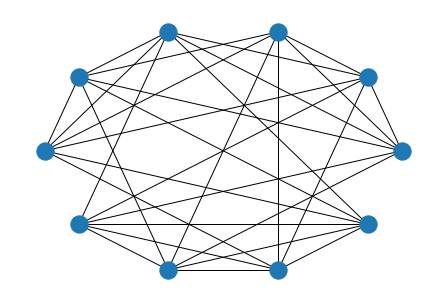

In [65]:
graph_file = "johnson8-2-4.mtx"
graph_type = 1

n = 10
G = nx.complement(load_graph(graph_file, graph_type, n))
nx.draw(G, nx.circular_layout(G))

# Max-cut

In [66]:
L = nx.laplacian_matrix(G).toarray() * 1.0

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [67]:
# x = cp.Variable(n)
# constraints = [ cp.square(x[i]) == 1 for i in range(n) ]
# prob = cp.Problem(cp.Minimize(cp.norm(x - x_0.T[0])), constraints)
# prob.solve()

In [68]:
X = cp.Variable((n,n), PSD=True)
constraints = [ X[i][i] == 1 for i in range(n) ]
prob = cp.Problem(cp.Maximize(1/4 * (cp.trace(L @ X))), constraints)
prob.solve()

19.999999999950337

In [69]:
np.linalg.eigvalsh(X.value)

array([-1.07219789e-12, -4.20981626e-13, -4.20457640e-13, -4.20244954e-13,
       -4.19902376e-13,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00])

In [70]:
hyperplane_cost, x_0 = hyperplane_rounding(decompose_psd(X.value), lambda Y : -1/4 * np.trace(Y @ Y.T @ L))
print(-hyperplane_cost)

20.0


In [71]:
X_hyperplane = np.outer(x_0, x_0)

In [72]:
# if x_0[0] < 0:
#     x_0 = -x_0
#
# # find X in the elliptope whose first column should be the same as x_0, due to the objective function
# X_close = cp.Variable((n,n), PSD=True)
# constraints = [ X_close[i][i] == 1 for i in range(n) ]
# prob = cp.Problem(cp.Maximize(cp.sum([x_0[i] * X_close[i][0] for i in range(n)])), constraints)
# prob.solve(solver=cp.MOSEK)
#
# print(np.linalg.eigvalsh(X_close.value))
# print(1/4 * np.trace(X_close.value @ L))

In [73]:
X_val = X.value

In [74]:
# 0 is not in the feasible region
X_path = fixed_point_iteration(prob, X, returns_path=True, tol=1e-6)
X_fixed_point = X.value
X.value = X_val

initial objective: 20.000000
initial eigenvalues:
[-1.07219789e-12 -4.20981626e-13 -4.20457640e-13 -4.20244954e-13
 -4.19902376e-13  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00]
fixed point objective: 20.000000
fixed point eigenvalues:
[-6.75860028e-09 -6.75859971e-09 -6.75859968e-09 -6.75859958e-09
 -6.75859942e-09  1.99999999e+00  1.99999999e+00  1.99999999e+00
  1.99999999e+00  1.99999999e+00]
iterations:  1


In [75]:
X_samples = sdp_sampling(prob, X, "maxcut", folder, graph_file, 1000)

In [76]:
row = 0
col = 1

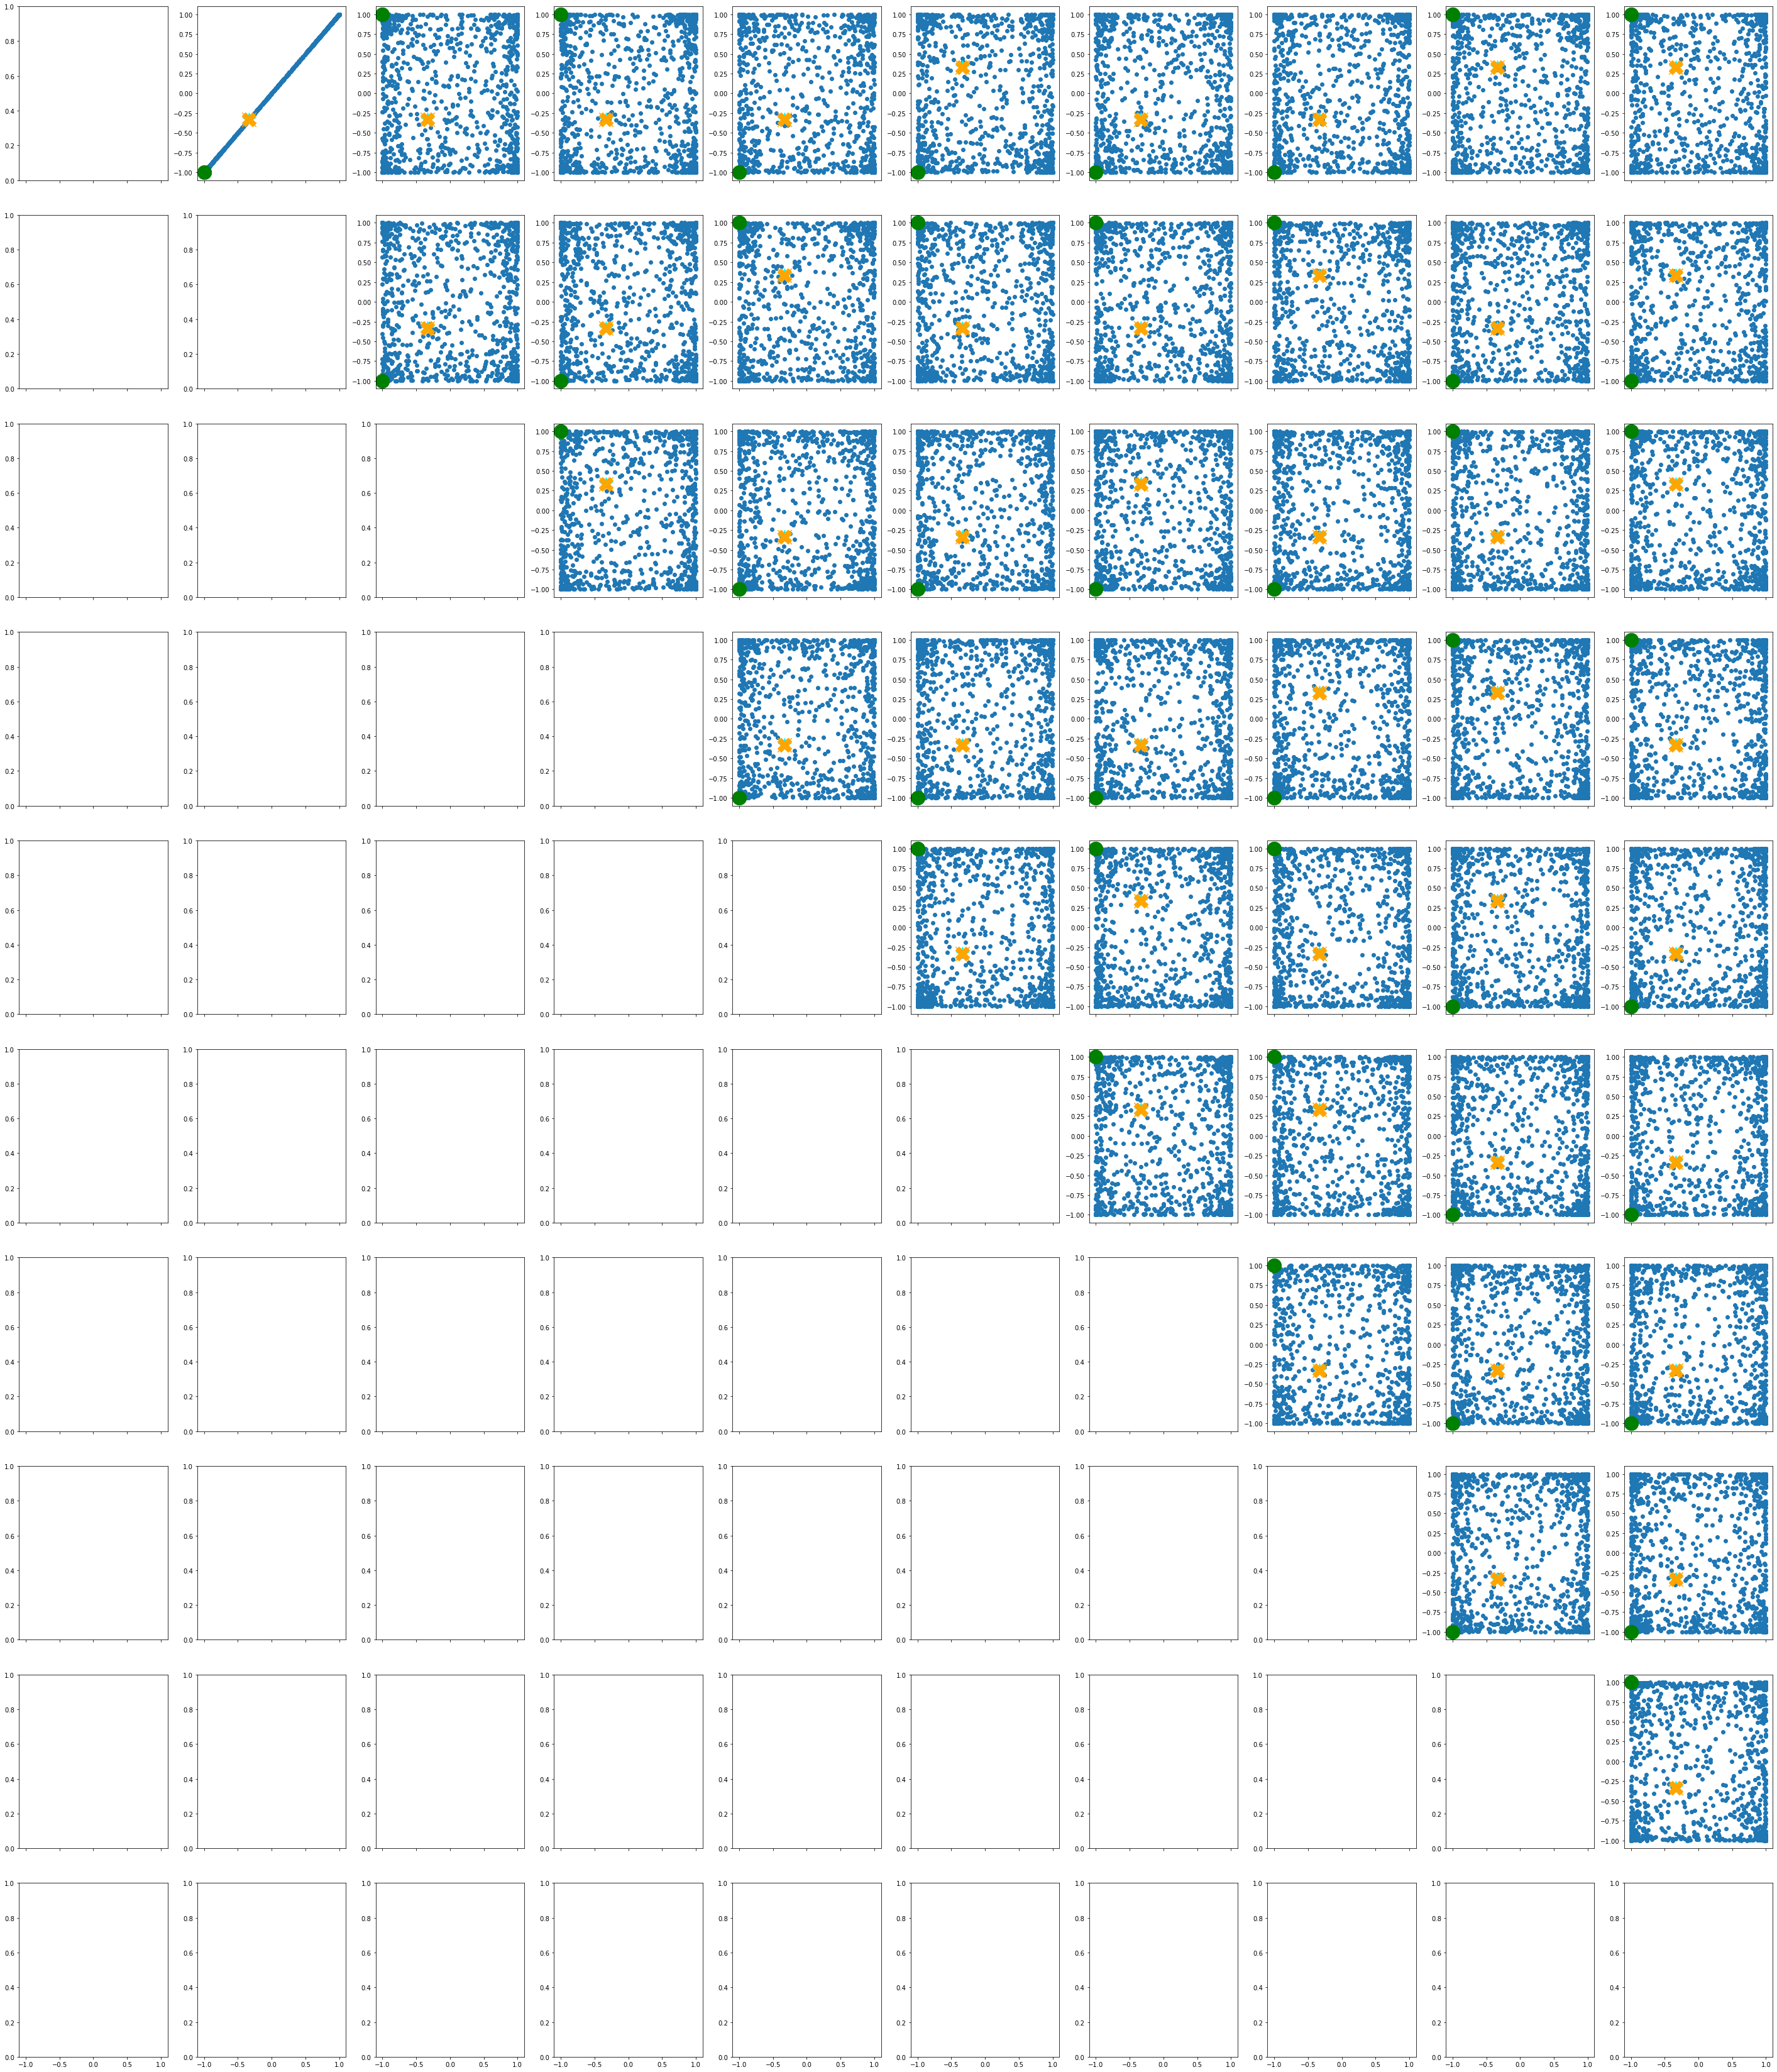

In [77]:
fig, axs = plt.subplots(n, n, figsize=(50, 60), sharex=True)

for i in range(n):
    for j in range(i + 1, n):
        axs[i, j].scatter(X_samples[:, row, col], X_samples[:, i, j])
        axs[i, j].scatter(X_val[row, col], X_val[i, j], c="aqua", s=5e2, marker="*")
        axs[i, j].scatter(X_fixed_point[row, col], X_fixed_point[i, j], c="orange", s=5e2, marker="X")
        axs[i, j].scatter(X_path[:, row, col], X_path[:, i, j], c="orange", s=5e2, marker="x")
        axs[i, j].scatter(X_hyperplane[row, col], X_hyperplane[i, j], c="green", s=5e2, marker="o")